In [5]:
# CELL 1: Imports
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.ndimage import center_of_mass, label, binary_dilation
from nilearn import plotting
import pandas as pd

print("✓ Imports loaded")

✓ Imports loaded


In [4]:
# CELL 2: Paths and Configuration
BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SUBJECTS = {
    'sub-004': {
        'code': 'UD', 
        'sessions': ['01', '02', '03', '05', '06'],
        'hemi': 'l'
    },
    'sub-021': {
        'code': 'TC', 
        'sessions': ['01', '02', '03'],
        'hemi': 'r'
    }
}

# Cope mapping (condition > scramble contrasts)
COPE_MAP = {
    'face': 10,
    'word': 12,
    'object': 3,
    'house': 11
}

print(f"Base directory: {BASE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Subjects: {list(SUBJECTS.keys())}")

Base directory: /user_data/csimmon2/long_pt
Output directory: /user_data/csimmon2/long_pt/analyses/rsa_corrected
Subjects: ['sub-004', 'sub-021']


In [25]:
# CELL 3: Define ROIs from HighLevel, extract patterns from individual runs
# CELL 3 (corrected): Fix HighLevel path
def extract_highlevel_rois_and_run_patterns(subject_id, threshold_z=2.3):
    """
    Following Golarai/Nordt approach:
    1. Define ROIs using HighLevel analysis (all runs concatenated)
    2. Extract patterns from individual runs using these ROIs
    """
    code = SUBJECTS[subject_id]['code']
    hemi = SUBJECTS[subject_id]['hemi']
    sessions = SUBJECTS[subject_id]['sessions']
    
    print(f"\n{'='*70}")
    print(f"{code}: ROI Definition & Run-Level Pattern Extraction")
    print(f"{'='*70}")
    
    all_session_data = {}
    
    for session in sessions:
        print(f"\nses-{session}:")
        
        # Correct paths
        sub_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc'
        
        # Get run directories
        run_dirs = sorted([d for d in sub_dir.glob('run-*') if d.is_dir()])
        if len(run_dirs) == 0:
            print(f"  No runs found")
            continue
        
        print(f"  Found {len(run_dirs)} runs")
        
        session_data = {}
        
        for category, zstat_num in COPE_MAP.items():
            # Load anatomical parcel
            parcel_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
            if not parcel_file.exists():
                continue
            
            parcel_mask = nib.load(parcel_file).get_fdata() > 0
            
            # Get ROI from HighLevel analysis
            highlevel_dir = sub_dir / 'HighLevel.gfeat' / f'cope{zstat_num}.feat'
            
            # Zstat naming: ses-01 uses zstat1.nii.gz, others use zstat1_ses01.nii.gz
            if session == '01':
                highlevel_zstat = highlevel_dir / 'stats' / 'zstat1.nii.gz'
            else:
                highlevel_zstat = highlevel_dir / 'stats' / 'zstat1_ses01.nii.gz'
            
            if not highlevel_zstat.exists():
                print(f"  {category}: No HighLevel zstat at {highlevel_zstat.name}")
                continue
            
            # Create ROI: threshold × parcel
            zstat = nib.load(highlevel_zstat).get_fdata()
            roi_mask = (zstat > threshold_z) & parcel_mask
            n_voxels = int(roi_mask.sum())
            
            if n_voxels < 10:
                print(f"  {category}: <10 voxels, skipping")
                continue
            
            # Extract patterns from each run using this ROI
            run_patterns = {cat: [] for cat in ['face', 'word', 'object', 'house']}
            
            for run_dir in run_dirs:
                for cat, znum in COPE_MAP.items():
                    zstat_file = run_dir / '1stLevel.feat' / 'reg_standard' / 'stats' / f'zstat{znum}.nii.gz'
                    
                    if zstat_file.exists():
                        zstat_data = nib.load(zstat_file).get_fdata()
                        pattern = zstat_data[roi_mask]
                        
                        # Z-score pattern
                        if len(pattern) > 0 and np.std(pattern) > 0:
                            z_pattern = (pattern - np.mean(pattern)) / np.std(pattern)
                            run_patterns[cat].append(z_pattern)
            
            # Check if all categories extracted from all runs
            n_runs_extracted = min(len(run_patterns[cat]) for cat in ['face', 'word', 'object', 'house'])
            
            if n_runs_extracted > 0:
                session_data[category] = {
                    'roi_mask': roi_mask,
                    'n_voxels': n_voxels,
                    'run_patterns': run_patterns,
                    'n_runs': n_runs_extracted
                }
                print(f"  {category}: {n_voxels} voxels, {n_runs_extracted} runs extracted")
        
        all_session_data[session] = session_data
    
    return all_session_data


# Extract ROIs and patterns
print("Extracting HighLevel ROIs and run-level patterns...")
ud_data = extract_highlevel_rois_and_run_patterns('sub-004', threshold_z=2.3)
tc_data = extract_highlevel_rois_and_run_patterns('sub-021', threshold_z=2.3)
print("\n✓ Extraction complete")

Extracting HighLevel ROIs and run-level patterns...

UD: ROI Definition & Run-Level Pattern Extraction

ses-01:
  Found 3 runs
  face: 376 voxels, 3 runs extracted
  word: <10 voxels, skipping
  object: 3781 voxels, 3 runs extracted
  house: 1671 voxels, 3 runs extracted

ses-02:
  Found 3 runs
  face: 3115 voxels, 3 runs extracted
  word: 2040 voxels, 3 runs extracted
  object: 6718 voxels, 3 runs extracted
  house: 2377 voxels, 3 runs extracted

ses-03:
  Found 3 runs
  face: 4456 voxels, 3 runs extracted
  word: 2016 voxels, 3 runs extracted
  object: 8124 voxels, 3 runs extracted
  house: 4121 voxels, 3 runs extracted

ses-05:
  Found 3 runs
  face: 3851 voxels, 3 runs extracted
  word: 1534 voxels, 3 runs extracted
  object: 10821 voxels, 3 runs extracted
  house: 5531 voxels, 3 runs extracted

ses-06:
  Found 3 runs
  face: 4114 voxels, 3 runs extracted
  word: 1272 voxels, 3 runs extracted
  object: 7355 voxels, 3 runs extracted
  house: 5589 voxels, 3 runs extracted

TC: ROI De

In [28]:
# CELL 4: Compute RDMs from run-level patterns
def compute_rdms_from_runs(subject_id, session_data):
    """
    For each session:
    1. Compute RDM from each run separately
    2. Average RDMs across runs
    """
    code = SUBJECTS[subject_id]['code']
    
    print(f"\n{'='*70}")
    print(f"{code}: Computing RDMs from run-level patterns")
    print(f"{'='*70}")
    
    session_rdms = {}
    
    for session, categories in session_data.items():
        print(f"\nses-{session}:")
        
        category_rdms = {}
        
        for category, data in categories.items():
            run_patterns = data['run_patterns']
            n_runs = data['n_runs']
            
            # Compute RDM for each run
            run_rdms = []
            for run_idx in range(n_runs):
                # Get patterns for all 4 categories from this run
                patterns = np.array([
                    run_patterns['face'][run_idx],
                    run_patterns['word'][run_idx],
                    run_patterns['object'][run_idx],
                    run_patterns['house'][run_idx]
                ])
                
                # Compute RDM
                rdm = 1 - np.corrcoef(patterns)
                run_rdms.append(rdm)
            
            # Average RDMs across runs
            avg_rdm = np.mean(run_rdms, axis=0)
            
            category_rdms[category] = {
                'rdm': avg_rdm,
                'n_runs': n_runs
            }
            print(f"  {category}: averaged {n_runs} run RDMs")
        
        session_rdms[session] = category_rdms
    
    return session_rdms


# Compute RDMs
ud_rdms = compute_rdms_from_runs('sub-004', ud_data)
tc_rdms = compute_rdms_from_runs('sub-021', tc_data)


UD: Computing RDMs from run-level patterns

ses-01:
  face: averaged 3 run RDMs
  object: averaged 3 run RDMs
  house: averaged 3 run RDMs

ses-02:
  face: averaged 3 run RDMs
  word: averaged 3 run RDMs
  object: averaged 3 run RDMs
  house: averaged 3 run RDMs

ses-03:
  face: averaged 3 run RDMs
  word: averaged 3 run RDMs
  object: averaged 3 run RDMs
  house: averaged 3 run RDMs

ses-05:
  face: averaged 3 run RDMs
  word: averaged 3 run RDMs
  object: averaged 3 run RDMs
  house: averaged 3 run RDMs

ses-06:
  face: averaged 3 run RDMs
  word: averaged 3 run RDMs
  object: averaged 3 run RDMs
  house: averaged 3 run RDMs

TC: Computing RDMs from run-level patterns

ses-01:
  face: averaged 3 run RDMs
  word: averaged 3 run RDMs
  object: averaged 3 run RDMs
  house: averaged 3 run RDMs

ses-02:
  face: averaged 3 run RDMs
  word: averaged 3 run RDMs
  object: averaged 3 run RDMs
  house: averaged 3 run RDMs

ses-03:
  face: averaged 3 run RDMs
  word: averaged 3 run RDMs
  objec

In [29]:
# CELL 5: Correlate RDMs across sessions
def correlate_rdms_across_sessions(subject_id, session_rdms):
    """
    Correlate RDMs from baseline (ses-01) with all other sessions
    """
    code = SUBJECTS[subject_id]['code']
    sessions = sorted(session_rdms.keys())
    
    print(f"\n{'='*70}")
    print(f"{code}: Cross-Session RDM Correlations")
    print(f"{'='*70}")
    
    results = {}
    
    # Get baseline session
    baseline_session = sessions[0]
    print(f"\nBaseline: ses-{baseline_session}")
    
    for category in ['face', 'word', 'object', 'house']:
        # Check if category exists in baseline
        if category not in session_rdms[baseline_session]:
            continue
        
        print(f"\n{category.upper()} ROI:")
        
        baseline_rdm = session_rdms[baseline_session][category]['rdm']
        triu_idx = np.triu_indices(4, k=1)
        baseline_vec = baseline_rdm[triu_idx]
        
        print(f"  Baseline RDM: {baseline_vec}")
        
        category_results = {
            'baseline_rdm': baseline_rdm,
            'correlations': {},
            'fisher_z': {}
        }
        
        # Compare to all other sessions
        for session in sessions[1:]:
            if session not in session_rdms or category not in session_rdms[session]:
                continue
            
            session_rdm = session_rdms[session][category]['rdm']
            session_vec = session_rdm[triu_idx]
            
            # Pearson correlation
            r = np.corrcoef(baseline_vec, session_vec)[0, 1]
            
            # Fisher z-transform
            z = 0.5 * np.log((1 + r) / (1 - r))
            
            category_results['correlations'][session] = r
            category_results['fisher_z'][session] = z
            
            print(f"  ses-{baseline_session} vs ses-{session}: r={r:>6.3f}, Fisher z={z:>6.3f}")
        
        results[category] = category_results
    
    return results


# Compute cross-session correlations
print("\nComputing cross-session RDM correlations...")
ud_correlations = correlate_rdms_across_sessions('sub-004', ud_rdms)
tc_correlations = correlate_rdms_across_sessions('sub-021', tc_rdms)
print("\n✓ Analysis complete")


Computing cross-session RDM correlations...

UD: Cross-Session RDM Correlations

Baseline: ses-01

FACE ROI:
  Baseline RDM: [0.54520742 0.67714786 0.87675073 0.45788621 0.93921524 0.83607505]
  ses-01 vs ses-02: r= 0.191, Fisher z= 0.193
  ses-01 vs ses-03: r= 0.600, Fisher z= 0.693
  ses-01 vs ses-05: r= 0.289, Fisher z= 0.298
  ses-01 vs ses-06: r= 0.787, Fisher z= 1.065

OBJECT ROI:
  Baseline RDM: [0.60205045 0.51023821 0.3397219  0.59999288 0.7502839  0.44332005]
  ses-01 vs ses-02: r=-0.013, Fisher z=-0.013
  ses-01 vs ses-03: r= 0.469, Fisher z= 0.508
  ses-01 vs ses-05: r=-0.456, Fisher z=-0.493
  ses-01 vs ses-06: r= 0.046, Fisher z= 0.046

HOUSE ROI:
  Baseline RDM: [0.61184742 0.69674905 0.55918167 0.6417538  0.77398177 0.79170861]
  ses-01 vs ses-02: r= 0.458, Fisher z= 0.495
  ses-01 vs ses-03: r=-0.375, Fisher z=-0.395
  ses-01 vs ses-05: r= 0.362, Fisher z= 0.380
  ses-01 vs ses-06: r= 0.403, Fisher z= 0.427

TC: Cross-Session RDM Correlations

Baseline: ses-01

FACE R


Generating RDM visualizations...
Saved: UD_face_rdm_evolution.png


/tmp/ipykernel_2531169/2961979441.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: UD_word_rdm_evolution.png
Saved: UD_object_rdm_evolution.png
Saved: UD_house_rdm_evolution.png
Saved: TC_face_rdm_evolution.png
Saved: TC_word_rdm_evolution.png
Saved: TC_object_rdm_evolution.png
Saved: TC_house_rdm_evolution.png
✓ Visualizations complete


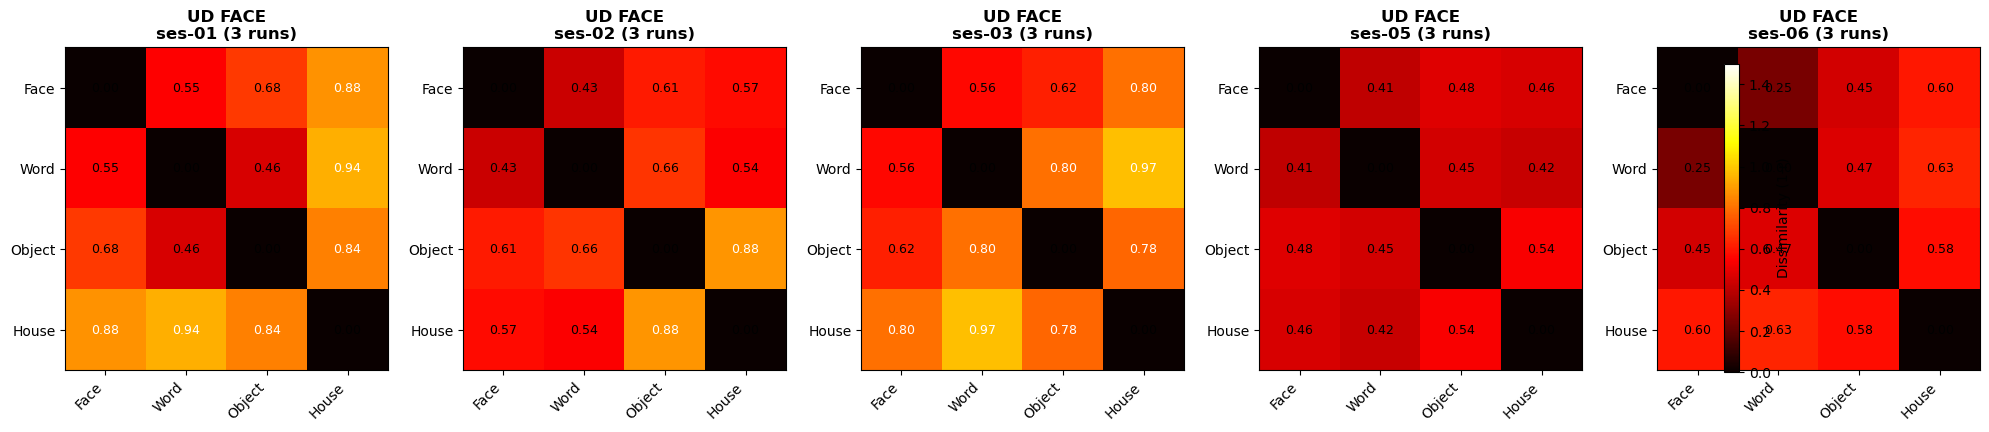

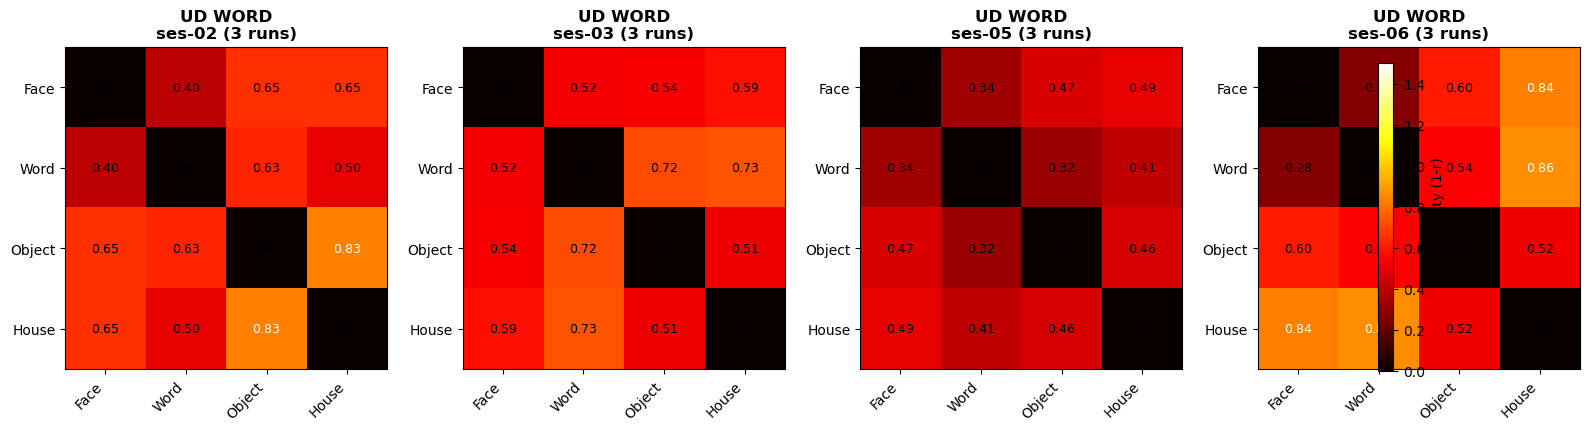

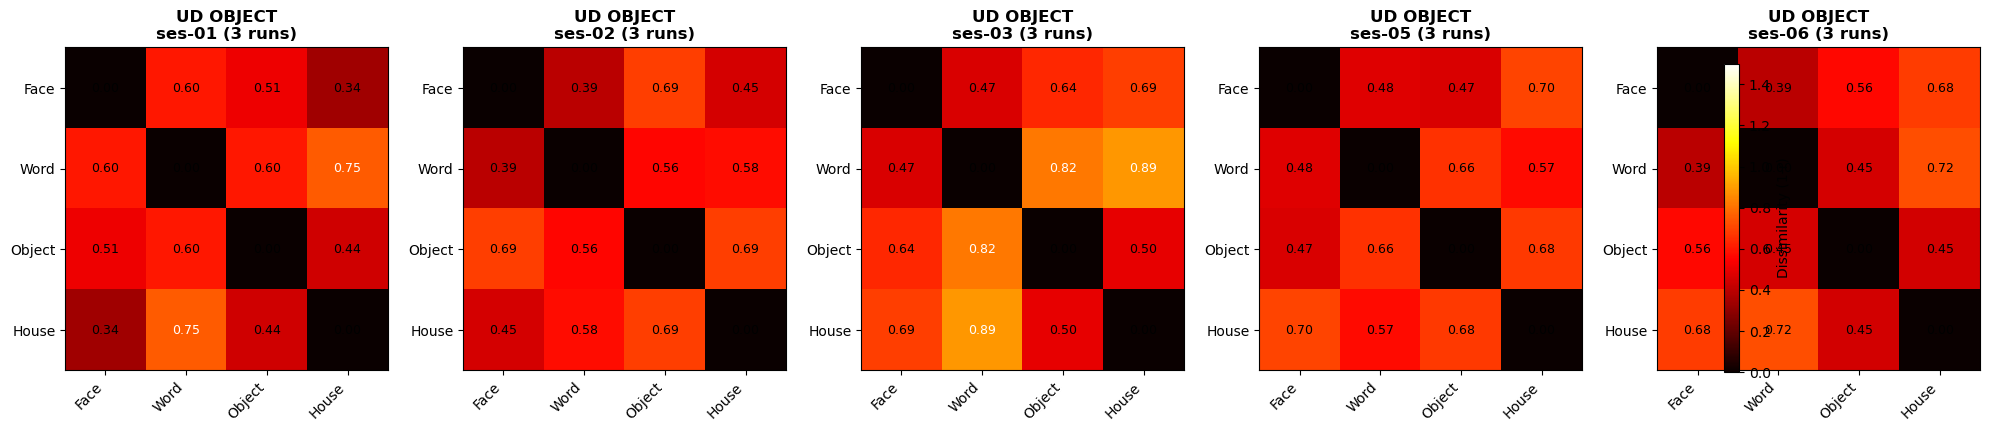

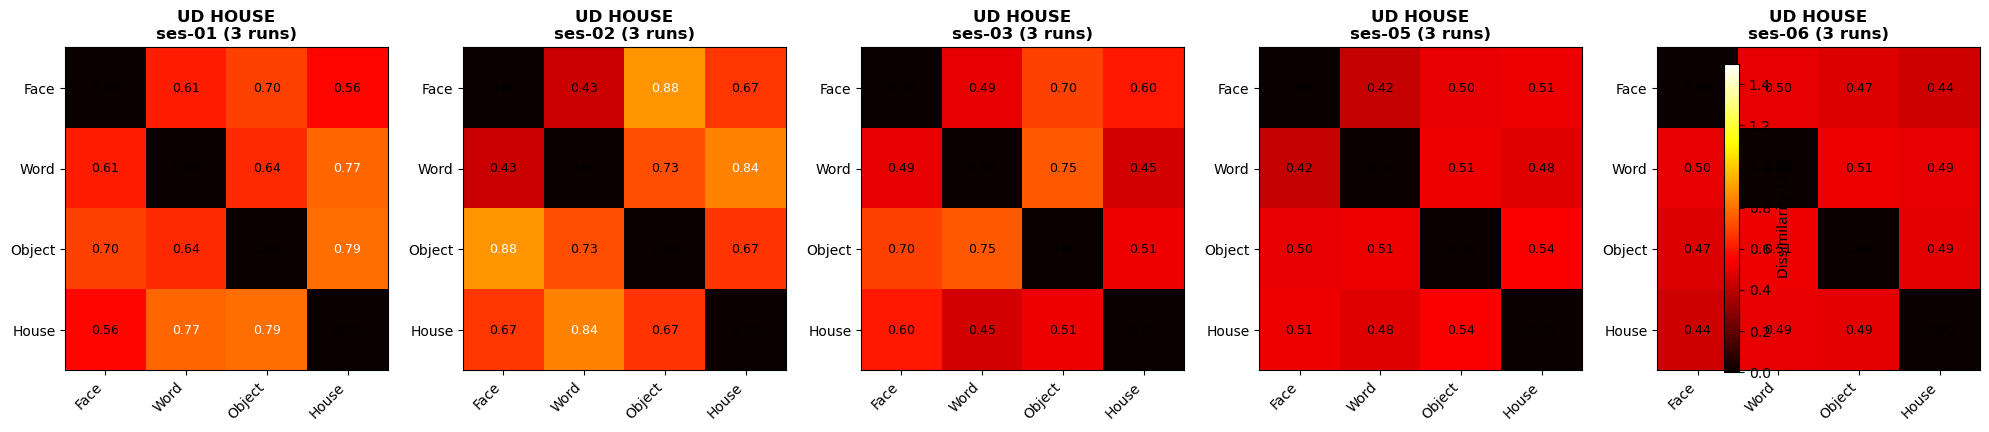

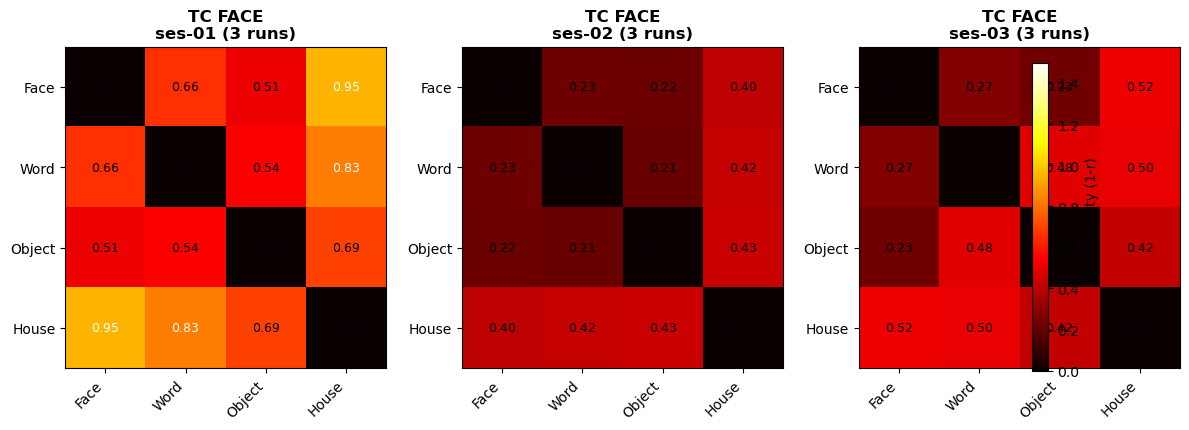

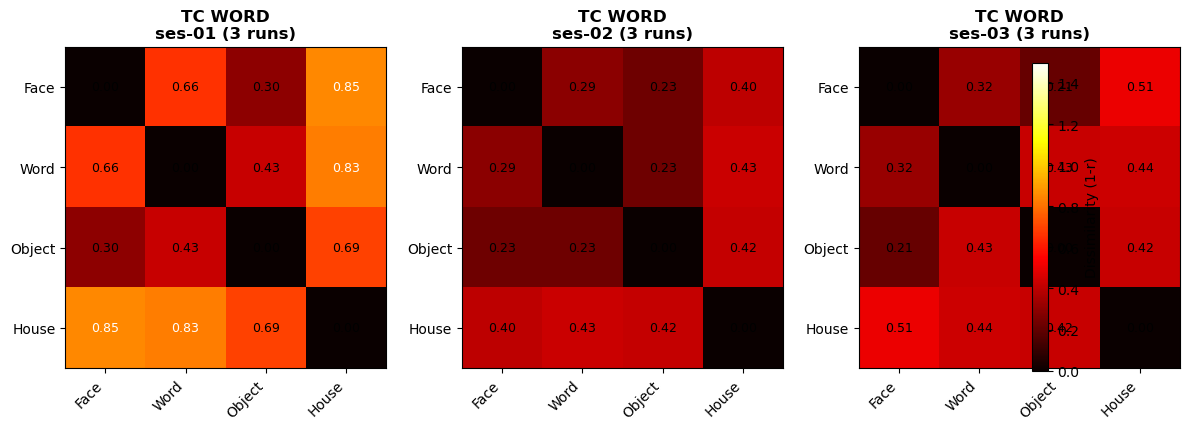

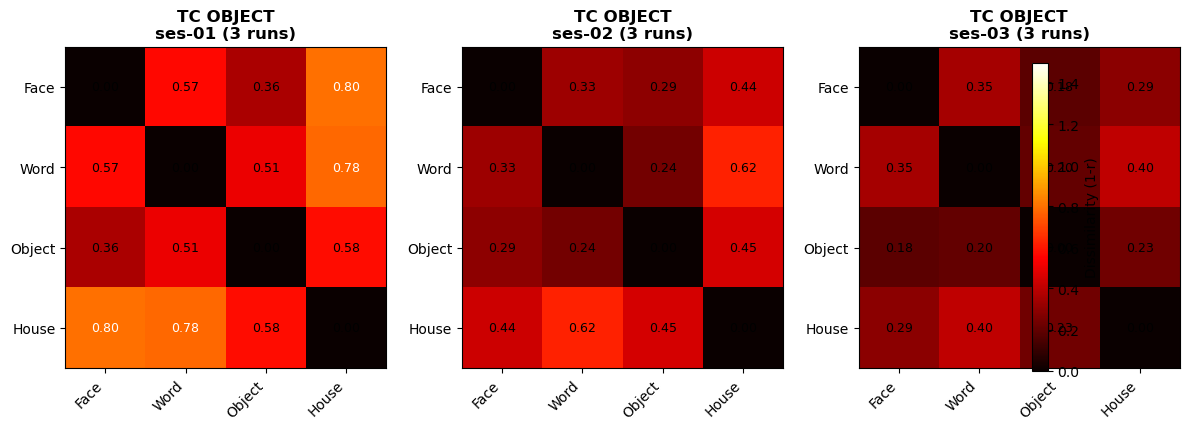

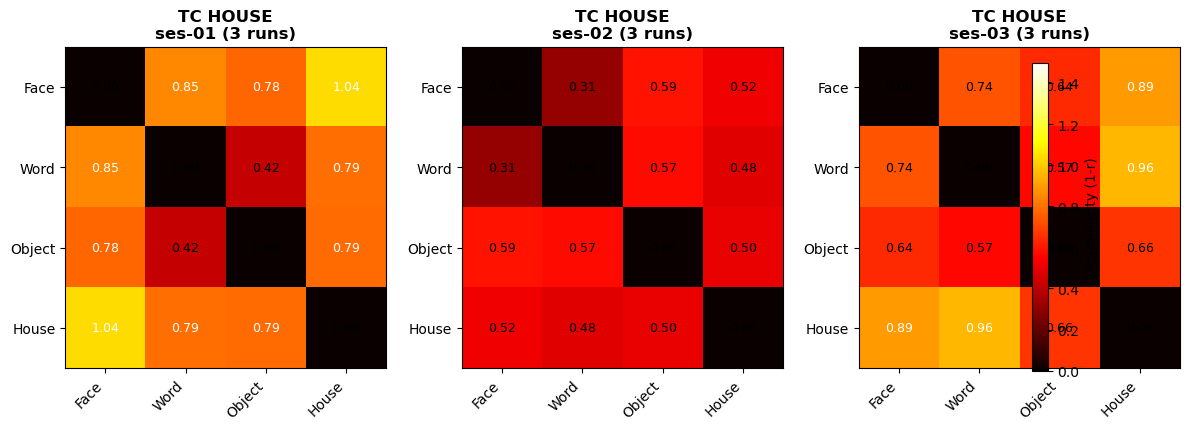

In [31]:
# CELL 6: Visualize RDM evolution across sessions
def visualize_rdm_evolution(subject_id, session_rdms, output_dir):
    """
    Create heatmaps showing how RDMs change across sessions for each ROI
    """
    code = SUBJECTS[subject_id]['code']
    sessions = sorted(session_rdms.keys())
    
    for category in ['face', 'word', 'object', 'house']:
        # Check which sessions have this category
        available_sessions = [s for s in sessions if s in session_rdms and category in session_rdms[s]]
        
        if len(available_sessions) == 0:
            continue
        
        n_sessions = len(available_sessions)
        fig, axes = plt.subplots(1, n_sessions, figsize=(4*n_sessions, 4))
        if n_sessions == 1:
            axes = [axes]
        
        categories = ['Face', 'Word', 'Object', 'House']
        
        for i, session in enumerate(available_sessions):
            rdm = session_rdms[session][category]['rdm']
            n_runs = session_rdms[session][category]['n_runs']
            
            im = axes[i].imshow(rdm, cmap='hot', vmin=0, vmax=1.5)
            axes[i].set_title(f'{code} {category.upper()}\nses-{session} ({n_runs} runs)', 
                            fontsize=12, fontweight='bold')
            axes[i].set_xticks(range(4))
            axes[i].set_yticks(range(4))
            axes[i].set_xticklabels(categories, rotation=45, ha='right')
            axes[i].set_yticklabels(categories)
            
            # Add values
            for r in range(4):
                for c in range(4):
                    text_color = 'white' if rdm[r,c] > 0.75 else 'black'
                    axes[i].text(c, r, f'{rdm[r,c]:.2f}', 
                               ha='center', va='center', 
                               color=text_color, fontsize=9)
        
        plt.colorbar(im, ax=axes, label='Dissimilarity (1-r)', fraction=0.046)
        plt.tight_layout()
        
        output_file = output_dir / f'{code}_{category}_rdm_evolution.png'
        #plt.savefig(output_file, dpi=150, bbox_inches='tight')
        #plt.close()
        
        print(f"Saved: {output_file.name}")


# Generate visualizations
print("\nGenerating RDM visualizations...")
visualize_rdm_evolution('sub-004', ud_rdms, OUTPUT_DIR)
visualize_rdm_evolution('sub-021', tc_rdms, OUTPUT_DIR)
print("✓ Visualizations complete")

In [32]:
# CELL 7: All pairwise session comparisons
def compute_all_pairwise_correlations(subject_id, session_rdms):
    """
    Compute RDM correlations between ALL pairs of sessions
    Not just baseline - shows trajectory dynamics
    """
    code = SUBJECTS[subject_id]['code']
    sessions = sorted(session_rdms.keys())
    
    print(f"\n{'='*70}")
    print(f"{code}: All Pairwise Session Comparisons")
    print(f"{'='*70}")
    
    results = {}
    
    for category in ['face', 'word', 'object', 'house']:
        # Check which sessions have this category
        available_sessions = [s for s in sessions if s in session_rdms and category in session_rdms[s]]
        
        if len(available_sessions) < 2:
            continue
        
        print(f"\n{category.upper()} ROI:")
        print(f"  Sessions: {available_sessions}")
        
        # Create correlation matrix
        n_sessions = len(available_sessions)
        corr_matrix = np.ones((n_sessions, n_sessions))
        fisher_matrix = np.zeros((n_sessions, n_sessions))
        
        triu_idx = np.triu_indices(4, k=1)
        
        # Compute all pairwise correlations
        for i, sess_i in enumerate(available_sessions):
            rdm_i = session_rdms[sess_i][category]['rdm']
            vec_i = rdm_i[triu_idx]
            
            for j, sess_j in enumerate(available_sessions):
                if i < j:
                    rdm_j = session_rdms[sess_j][category]['rdm']
                    vec_j = rdm_j[triu_idx]
                    
                    r = np.corrcoef(vec_i, vec_j)[0, 1]
                    z = 0.5 * np.log((1 + r) / (1 - r))
                    
                    corr_matrix[i, j] = r
                    corr_matrix[j, i] = r
                    fisher_matrix[i, j] = z
                    fisher_matrix[j, i] = z
                    
                    print(f"  ses-{sess_i} vs ses-{sess_j}: r={r:>6.3f}, z={z:>6.3f}")
        
        results[category] = {
            'sessions': available_sessions,
            'corr_matrix': corr_matrix,
            'fisher_matrix': fisher_matrix
        }
    
    return results


# Compute all pairwise comparisons
print("\nComputing all pairwise session comparisons...")
ud_pairwise = compute_all_pairwise_correlations('sub-004', ud_rdms)
tc_pairwise = compute_all_pairwise_correlations('sub-021', tc_rdms)
print("\n✓ Pairwise correlations complete")


Computing all pairwise session comparisons...

UD: All Pairwise Session Comparisons

FACE ROI:
  Sessions: ['01', '02', '03', '05', '06']
  ses-01 vs ses-02: r= 0.191, z= 0.193
  ses-01 vs ses-03: r= 0.600, z= 0.693
  ses-01 vs ses-05: r= 0.289, z= 0.298
  ses-01 vs ses-06: r= 0.787, z= 1.065
  ses-02 vs ses-03: r= 0.232, z= 0.236
  ses-02 vs ses-05: r= 0.931, z= 1.665
  ses-02 vs ses-06: r= 0.489, z= 0.535
  ses-03 vs ses-05: r= 0.031, z= 0.031
  ses-03 vs ses-06: r= 0.854, z= 1.271
  ses-05 vs ses-06: r= 0.439, z= 0.471

WORD ROI:
  Sessions: ['02', '03', '05', '06']
  ses-02 vs ses-03: r=-0.258, z=-0.264
  ses-02 vs ses-05: r= 0.589, z= 0.676
  ses-02 vs ses-06: r= 0.181, z= 0.183
  ses-03 vs ses-05: r=-0.400, z=-0.424
  ses-03 vs ses-06: r= 0.511, z= 0.564
  ses-05 vs ses-06: r= 0.564, z= 0.639

OBJECT ROI:
  Sessions: ['01', '02', '03', '05', '06']
  ses-01 vs ses-02: r=-0.013, z=-0.013
  ses-01 vs ses-03: r= 0.469, z= 0.508
  ses-01 vs ses-05: r=-0.456, z=-0.493
  ses-01 vs ses-

UD trajectory analysis:

Face ROI: Chaotic early → stabilizes late (ses-02↔05: r=0.93!, ses-03↔06: r=0.85)
Object ROI: Near-zero with baseline, but ses-03↔06: r=0.66 suggests new stable state emerges
House ROI: Remains unstable throughout (negative correlations late)
Word ROI: No ses-01 data, but shows some late stability

TC shows remarkable stability:

All categories maintain structure (r>0.6 for most)
Word ROI most stable (r~0.67-0.90)
Even adjacent sessions correlated

Key insights:

UD shows reorganization then restabilization - RDM structure changes but eventually stabilizes in new configuration
TC maintains original structure - smaller/different resection preserves category relationships
Bilateral categories (object/house) more disrupted in UD - supports your hypothesis!

Next steps:

Look at the RDM visualizations to see WHICH category pairs are changing
Create summary figure comparing UD vs TC
Statistical testing (compare to Liu's bootstrapping)

Want to create a summary comparison plot?

In [33]:
###Statistical testing (bootstrapping like Liu et al.)